<a href="https://colab.research.google.com/github/ChengyuZhu/Python-Project-EDA-and-Multivariate-Analysis/blob/master/EDA_%26_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


# EDA

In [198]:
#Load Data
df = pd.read_csv("bank-additional-full.csv", delimiter= ';')
df.rename(columns={"default": "creditdefault"}, inplace= True)
df.head()
#there are 21 cols, 41188 rows.

,age,job,marital,education,creditdefault,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [199]:
df.columns
#Bank cilent data: 'age', 'job', 'marital', 'education', 'default', 'housing(loan)', 'loan'
#Campaing/contact data: 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome'
#Social and economic data:'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'
#Target: 'y'

Index(['age', 'job', 'marital', 'education', 'creditdefault', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [200]:
df.count()
if (len([*filter(lambda x: x == False, list(df.columns.values))]) > 0) == False:
    print('No col has missing rows')
else:
  for i in list(df.columns.values):
    if df[i].isnull().values.any() == True:
      print(i)
#There's no missing value, excellent! But...Missing values are recorded as "unknown".

No col has missing rows


In [201]:
missing = []
#check how many missing value exists in each columns
for i in list(df.columns.values):
  if df[i].dtypes == 'O':
    if len(df[df[i].str.upper() == 'UNKNOWN'])>0 :
      missing.append( i + ':' + str(len(df[df[i].str.upper() == 'UNKNOWN'])) + ", " + str(round((len(df[df[i].str.upper() == 'UNKNOWN']) / len(df['age'])),2)))
    if len(df[df[i].str.upper() == 'NONEXISTENT'])>0 :
      missing.append( i + ':' + str(len(df[df[i].str.upper() == 'NONEXISTENT'])) + ", " + str(round((len(df[df[i].str.upper() == 'NONEXISTENT']) / len(df['age'])),2))) 
  else:
    if len(df[df[i] == 999])>0 :
      missing.append( i + ':' + str(len(df[df[i] == 999])) + ", " + str(round((len(df[df[i] == 999]) / len(df['age'])),2)))
print('numbers of missing value of each col: ', missing)
# The types of col having missing values are all object
# The percentage of cols having missing values are very small, except creditdefault, pdays, and poutcome
# we can find that most people didn't have been contacted before, and don't have poutcome results

numbers of missing value of each col:  ['job:330, 0.01', 'marital:80, 0.0', 'education:1731, 0.04', 'creditdefault:8597, 0.21', 'housing:990, 0.02', 'loan:990, 0.02', 'duration:2, 0.0', 'pdays:39673, 0.96', 'poutcome:35563, 0.86']


In [202]:
#change binary string values to numbers
df.y=df.y.replace(to_replace=['no', 'yes'], value=[0, 1])
df.head()

,age,job,marital,education,creditdefault,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


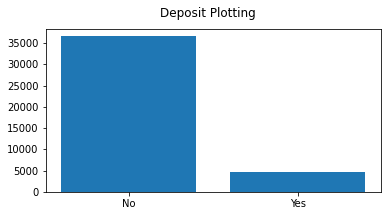

ratio No:Yes is:  7.876724137931035


In [203]:
#Explore distribution of opening deposit
values=df['y'].value_counts()
names=['No', 'Yes']
plt.figure(figsize=(6, 3))
plt.subplot()
plt.bar(names, values)
plt.suptitle('Deposit Plotting')
plt.show()
df
ratio = len(df[df['y'] == 0 ])/len(df[df['y'] == 1 ])
print('ratio No:Yes is: ', ratio)
#there is a obvious imbalance between y = 0 ('No') and y = 1 ('Yes'), need to resampling later

Explore Numeric variables

In [204]:
#calculate correlations
correlation = df.corr()
correlation.style.background_gradient(cmap='Blues')

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703,0.405274
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678


In [205]:
df_corr = df.corr().unstack().sort_values(ascending = False).drop_duplicates()
df_corr = pd.DataFrame(df_corr, columns=['Variable']) 

#choose corr = 0.7 as the threshold
df_big_corr = df_corr[abs(df_corr['Variable']) >= 0.7]
df_big_corr

#social & economic data have strong correlation
#euribor3m & emp.var.rate & nr.employed has strong correlation, we can only keep one of them afterwards

Variable
y            y               1.000000
euribor3m    emp.var.rate    0.972245
nr.employed  euribor3m       0.945154
             emp.var.rate    0.906970
emp.var.rate cons.price.idx  0.775334



Explore Client variables

In [206]:
# plot distribution
def stack_bar(df: pd.DataFrame, column: str):
    labels = []
    yes = []
    no = []

    yes_dict = dict(df[df['y'] == 1][column].value_counts())

    for key, value in yes_dict.items():
        labels.append(key)
        yes.append(value)
    
    for i in labels:
        no.append(dict(df[df[column] == i][df['y'] == 0][column].value_counts())[i])

    labels.reverse()
    yes.reverse()   
    no.reverse()    

    plt.figure(figsize=(6, 4))      
    plt.barh(labels, yes, color="#ffd159", label='Yes deposit')
    plt.barh(labels, no, left=yes, color="#5fb6c7", label='No deposit')

    plt.ylabel(f'{column}')
    plt.xlabel('Number of Clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.legend()
    plt.show();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


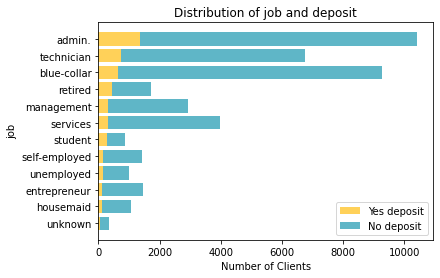

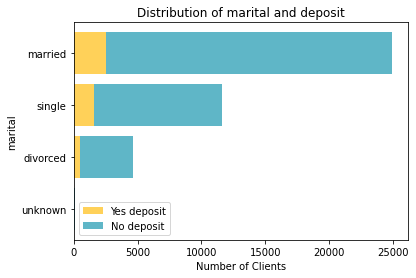

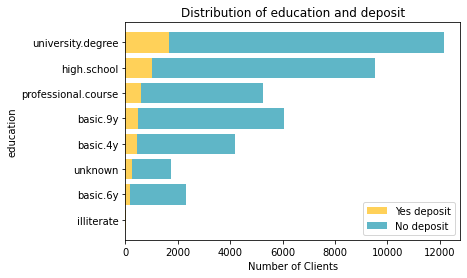

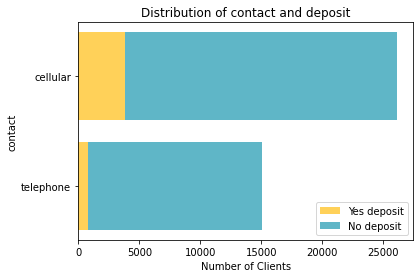

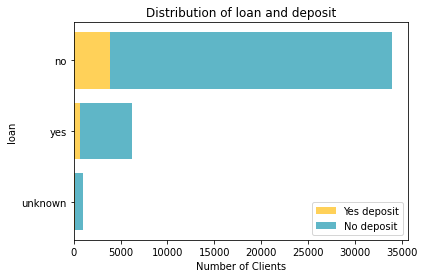

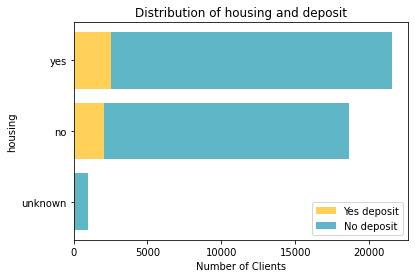

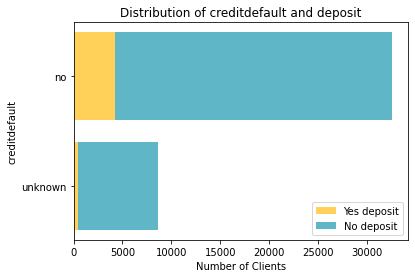

(None, None)

In [207]:
#get plots to visualize the client data with target variable
stack_bar(df, 'job'), stack_bar(df, 'marital'), stack_bar(df, 'education'), stack_bar(df, 'contact'), stack_bar(df, 'loan'), 
stack_bar(df, 'housing'), stack_bar(df, 'creditdefault')

In [208]:
#notice that ppl who has credit in default no or unknown likely haven't deposit, for people has credit in default yes ： 
print('numbers of rows that credit in default is "yes": ', len(df[df['creditdefault'] == 'yes']))
df[df['creditdefault'] == 'yes']
#people have credit in default don't have deposit!! :o

numbers of rows that credit in default is "yes":  3


,age,job,marital,education,creditdefault,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
21580,48,technician,married,professional.course,yes,no,no,cellular,aug,tue,66,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
21581,48,technician,married,professional.course,yes,yes,no,cellular,aug,tue,133,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
24866,31,unemployed,married,high.school,yes,no,no,cellular,nov,tue,111,2,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,0


##### Before we do deep analysis, let's dealt with some problems: 
##### continous variables: correlation, and '999' numbers (means client was not previously contacted)
##### categorical variables: missing values, and dummy variables

Sequence: 
1. dummy variables
2. deal with missing data (and '999' numbers)
3. correlation

In [209]:
#get dummy variables
df1 = df.copy()

df1.contact=df.contact.replace(to_replace=['cellular', 'telephone'], value=[1,0])
df1.loan=df.loan.replace(to_replace=['yes', 'no'], value=[1,0])
df1.housing=df.housing.replace(to_replace=['yes', 'no'],value=[1,0])
df1.creditdefault=df.creditdefault.replace(to_replace=['yes', 'no'],value=[1,0])
df1.poutcome=df.poutcome.replace(to_replace=['success', 'failure'],value=[1,0])
# df1.y = df.y.replace(to_replace=['yes', 'no'],value=[1,0]) #already replaced before
df1 = df1.replace('unknown', np.nan).replace('nonexistent', np.nan).replace(999, np.nan)
df1.head()

,age,job,marital,education,creditdefault,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,0.0,0.0,0.0,0,may,mon,261.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,0.0,0.0,0,may,mon,149.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,0.0,1.0,0.0,0,may,mon,226.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,0.0,0.0,0.0,0,may,mon,151.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,0.0,0.0,1.0,0,may,mon,307.0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0


According to the original dataset: duration attribute highly affects the output target and the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. Thus, the column will be droped.

In [210]:
df1 = df1.drop(axis=1, columns='duration')

In [211]:
#deal with missing values
#numbers of missing value of each col: ['job:330, 0.01', 'marital:80, 0.0', 'education:1731, 0.04', 'creditdefault:8597, 0.21', 'housing:990, 0.02', 
#'loan:990, 0.02', 'duration:2, 0.0', 'pdays:39673, 0.96', 'poutcome:35563, 0.86'], duration has been deleted

missing_list =  ['job', 'marital', 'education', 'creditdefault', 'housing', 'loan', 'pdays','poutcome']

for i in missing_list:
  counts = df1.groupby([i]).agg(len) 
  print(counts)

                 age  marital  education  ...  euribor3m  nr.employed      y
job                                       ...                               
admin.         10422    10422      10422  ...    10422.0      10422.0  10422
blue-collar     9254     9254       9254  ...     9254.0       9254.0   9254
entrepreneur    1456     1456       1456  ...     1456.0       1456.0   1456
housemaid       1060     1060       1060  ...     1060.0       1060.0   1060
management      2924     2924       2924  ...     2924.0       2924.0   2924
retired         1720     1720       1720  ...     1720.0       1720.0   1720
self-employed   1421     1421       1421  ...     1421.0       1421.0   1421
services        3969     3969       3969  ...     3969.0       3969.0   3969
student          875      875        875  ...      875.0        875.0    875
technician      6743     6743       6743  ...     6743.0       6743.0   6743
unemployed      1014     1014       1014  ...     1014.0       1014.0   1014

my current plan is:
1. for job, marital, education, housing, loan, duration: just drop the rows with missing values
2. for creditdefault: use method to impute the missing values
3. for poutcome and pdays: may drop the columns or use method to impute the missing values

In [212]:
#drop rows:
df1 = df1.dropna(subset=['job', 'marital', 'education', 'housing', 'loan'])

In [213]:
#use demographic infor to deduce the creditdefault:
#dummy coding some variables
df2=pd.get_dummies(df1, drop_first = True)
df2.columns.to_list()

['age',
 'creditdefault',
 'housing',
 'loan',
 'contact',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_married',
 'marital_single',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed']

In [214]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

credit_x = df2.dropna(subset=['creditdefault'])[['age' , 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married',
 'marital_single',  'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course',
 'education_university.degree']]
credit_y = df2.dropna(subset=['creditdefault'])['creditdefault']

from imblearn.over_sampling import RandomOverSampler
ros_credit = RandomOverSampler(random_state=0)
columns = credit_x.columns
credit_x_train, credit_x_test, credit_y_train, credit_y_test = train_test_split(credit_x, credit_y, test_size=0.33, random_state=42)

re_data_x,re_data_y=ros_credit.fit_sample(credit_x_train, credit_y_train)
re_data_x = pd.DataFrame(data=re_data_x, columns=columns)
re_data_y= pd.DataFrame(data=re_data_y,columns=['creditdefault'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [215]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(re_data_x , re_data_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [216]:
#check accuracy
test_pred = clf_tree.predict(credit_x_test)
test_score = accuracy_score(credit_y_test, test_pred)
print(test_score)
#I'm shocked!

0.9998012323593719


In [218]:
credit_pred = clf_tree.predict(df2[df2['creditdefault'].isnull()][['age' , 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married',
 'marital_single',  'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course',
 'education_university.degree']])
# credit_pred.shape

In [219]:
n = 0
for i in df2[df2['creditdefault'].isnull()].index:
  
             df2['creditdefault'][i] = credit_pred[n]
             n = n+1

df2.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,age,creditdefault,housing,loan,contact,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,0.0,0.0,0.0,0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,57,0.0,0.0,0.0,0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,37,0.0,1.0,0.0,0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,40,0.0,0.0,0.0,0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,56,0.0,0.0,1.0,0,1,NaN,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [220]:
#analyze poutcome (86% are missing valule) and pdays(96% are missing values):
print('After split the dataset according to whether pdays has missing values or not, if pdays does not have missing values, poutcome has', df2[df2['pdays'].isnull() == False]['poutcome'].isnull().sum(), 'missing value(s).')
df2[df2['pdays'].isnull() == False].shape

After split the dataset according to whether pdays has missing values or not, if pdays does not have missing values, poutcome has 0 missing value(s).


(1366, 46)

In [221]:
#let me simply drop pdays lol
df3 = df2.drop('pdays', axis = 1)
df3.head()

,age,creditdefault,housing,loan,contact,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,56,0.0,0.0,0.0,0,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,57,0.0,0.0,0.0,0,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,37,0.0,1.0,0.0,0,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,40,0.0,0.0,0.0,0,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,56,0.0,0.0,1.0,0,1,0,NaN,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [222]:
#for poutcome, it isn't reasonable to use 14% rows to predict 86% values. Thus, I made a tough decision, I wanted to drop the column.
df3 = df3.drop ('poutcome', axis = 1)
#maybe I can categorize 'nonexistent', instead of them as null values. I can test this idea afterwards.
# df4 = df3['poutcome'].fillna(value= 'nonexistent', inplace= True )

After processing missing values, let's deal with correlation.

In [223]:
#correlation:
#review that: euribor3m & emp.var.rate & nr.employed has strong correlation, we can only keep one of them afterwards
correlation = df3.corr()
correlation.style.background_gradient(cmap='Blues')

In [224]:
#choose corr = 0.7 as the threshold
df3_corr = df3.corr().unstack().sort_values(ascending = False).drop_duplicates()
df3_corr = pd.DataFrame(df3_corr, columns=['Variable']) 
df3_big_corr = df3_corr[abs(df3_corr['Variable']) >= 0.7]
df3_big_corr
#euribor3m & emp.var.rate & nr.employed has strong correlation, we can only keep one of them afterwards
#marital status are highly negative correlated?!
#emp.var.rate and cons.price.idx are highly correlated.
#New question arouses: should i consider date? :(

,,Variable
day_of_week_wed,day_of_week_wed,1.000000
emp.var.rate,euribor3m,0.972422
euribor3m,nr.employed,0.945336
nr.employed,emp.var.rate,0.907920
emp.var.rate,cons.price.idx,0.775418
marital_married,marital_single,-0.776250


Let's analyze the data now, don't forget to the imbalance problem!

In [225]:
#resampling the dataset:
from imblearn.over_sampling import SMOTE
x = df3.loc[:, df3.columns != 'y']
y = df3.loc[:, df3.columns == 'y']
resample_smote = SMOTE(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = x_train.columns
smote_data_x,smote_data_y=resample_smote.fit_sample(x_train, y_train)
smote_data_x = pd.DataFrame(data=smote_data_x, columns=columns)
smote_data_y= pd.DataFrame(data=smote_data_y, columns=['y'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression:

In [226]:
#use logistic regression to analyze the dataset:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
#do feature selection:
clf_log = LogisticRegression()
rfe_log = RFE(clf_log , 20)
rfe_log = rfe_log.fit(smote_data_x, smote_data_y.values.ravel())
print(rfe_log.support_)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[False False False  True  True False  True False False False  True False
  True  True  True False  True  True  True  True False False False False
 False False False False False False False  True  True  True  True  True
  True  True False  True  True False False]


In [227]:
#The REF helps select features as: 
columns_log = []
for i in range(len(smote_data_x.columns)):
  if rfe_log.support_[i] == True:
    columns_log.append(smote_data_x.columns.to_list()[i])
print('The REF helps select features as:', columns_log)

The REF helps select features as: ['loan', 'contact', 'previous', 'euribor3m', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'day_of_week_mon', 'day_of_week_thu']


In [228]:
#recheck the correlation
correlation_log = smote_data_x[columns_log].corr()
correlation_log.style.background_gradient(cmap='Blues')
#looks much better

,loan,contact,previous,euribor3m,job_blue-collar,job_entrepreneur,job_housemaid,job_retired,job_self-employed,job_services,job_student,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,day_of_week_mon,day_of_week_thu
loan,1.000000,-0.000820,-0.003367,0.005279,-0.009151,-0.010777,-0.007309,-0.002599,-0.009313,0.006748,0.023544,0.016567,0.009946,0.002156,-0.005298,0.003726,0.004346,-0.011638,0.014885,0.010449
contact,-0.000820,1.000000,0.212421,-0.434997,-0.134894,-0.041046,-0.019311,0.055924,-0.002428,-0.058846,0.052518,0.039505,0.162109,-0.310736,0.085181,-0.337614,0.118531,0.042039,0.015730,0.040104
previous,-0.003367,0.212421,1.000000,-0.476816,-0.109255,-0.039190,0.006254,0.093948,-0.023814,-0.040570,0.101508,0.055418,-0.112484,-0.053045,0.054375,-0.071595,0.085236,0.125725,-0.019685,0.016827
euribor3m,0.005279,-0.434997,-0.476816,1.000000,0.136525,0.047876,0.018689,-0.147456,0.013918,0.068256,-0.157250,-0.120953,0.303912,0.086558,-0.181627,-0.005447,0.029803,-0.190278,0.000470,-0.034965
job_blue-collar,-0.009151,-0.134894,-0.109255,0.136525,1.000000,-0.082675,-0.076327,-0.124451,-0.090135,-0.144181,-0.091279,-0.035433,0.031914,0.036058,-0.053159,0.185516,-0.057793,-0.070942,-0.016410,-0.004106
job_entrepreneur,-0.010777,-0.041046,-0.039190,0.047876,-0.082675,1.000000,-0.025327,-0.045802,-0.030084,-0.054099,-0.033140,-0.010028,-0.001998,0.021799,-0.034501,0.009479,0.041228,-0.020166,0.004267,0.001935
job_housemaid,-0.007309,-0.019311,0.006254,0.018689,-0.076327,-0.025327,1.000000,-0.022930,-0.030164,-0.049502,-0.031436,0.048415,0.014666,-0.009428,-0.020943,-0.013467,-0.008597,-0.000311,-0.003379,0.000021
job_retired,-0.002599,0.055924,0.093948,-0.147456,-0.124451,-0.045802,-0.022930,1.000000,-0.048313,-0.081619,-0.049694,0.038465,-0.004332,-0.037219,0.043638,-0.096462,0.003566,0.091504,0.002811,-0.022482
job_self-employed,-0.009313,-0.002428,-0.023814,0.013918,-0.090135,-0.030084,-0.030164,-0.048313,1.000000,-0.056201,-0.033953,0.012285,-0.015892,0.013846,-0.001151,-0.015333,0.021895,-0.024132,0.012698,0.022556
job_services,0.006748,-0.058846,-0.040570,0.068256,-0.144181,-0.054099,-0.049502,-0.081619,-0.056201,1.000000,-0.053652,-0.019051,0.039480,0.003078,-0.035336,0.089613,-0.030034,-0.026797,0.010931,0.001105


In [229]:
#implementing the logistic regression:
import statsmodels.api as sm
clf_logit = sm.Logit(smote_data_y, smote_data_x[columns_log])
result=clf_logit.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.566725
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.182     
Dependent Variable:  y                AIC:              53890.2463
Date:                2020-07-15 19:01 BIC:              54065.6202
No. Observations:    47510            Log-Likelihood:   -26925.   
Df Model:            19               LL-Null:          -32931.   
Df Residuals:        47490            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
loan              -0.1011   0.0312  -3.2438 0.0012 -0.1622 -0.0400
contact            0.8691   0.0209  41.5567 0.0000  0

In [230]:
#according to the summary, the new features selected are:
columns_log = ['loan', 'contact', 'previous', 'euribor3m', 'job_blue-collar', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_oct', 'day_of_week_mon']
clf_logit = sm.Logit(smote_data_y, smote_data_x[columns_log])
result=clf_logit.fit()
print(result.summary2())
#nice result!

Optimization terminated successfully.
         Current function value: 0.566780
         Iterations 6
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.182     
Dependent Variable:  y                AIC:              53887.4399
Date:                2020-07-15 19:01 BIC:              54027.7390
No. Observations:    47510            Log-Likelihood:   -26928.   
Df Model:            15               LL-Null:          -32931.   
Df Residuals:        47494            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      6.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
loan              -0.1023   0.0312  -3.2840 0.0010 -0.1634 -0.0412
contact            0.8592   0.0200  43.0617 0.0000  0

In [231]:
#Using logistic Regression to fit the model:
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(smote_data_x[columns_log], smote_data_y['y'], test_size=0.3, random_state=0)
clf_log1 = LogisticRegression(max_iter=100)
clf_log1.fit(x_train_log, y_train_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [232]:
# predict the results and caluculte the accuracy:
y_pred_log = clf_log1.predict(x_test_log)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf_log1.score(x_test_log, y_test_log)))

Accuracy of logistic regression classifier on test set: 0.73


In [233]:
#confusion matrix:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test_log, y_pred_log)
print('confusion_matrix:\n', confusion_matrix)
print(classification_report(y_test_log, y_pred_log))

confusion_matrix:
 [[5565 1528]
 [2376 4784]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      7093
           1       0.76      0.67      0.71      7160

    accuracy                           0.73     14253
   macro avg       0.73      0.73      0.73     14253
weighted avg       0.73      0.73      0.73     14253



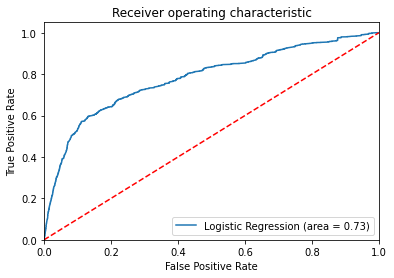

In [234]:
#roc curve:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test_log, clf_log1.predict(x_test_log))
fpr, tpr, thresholds = roc_curve(y_test_log, clf_log1.predict_proba(x_test_log)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Random Forest:

In [235]:
#get resampled x_train: smote_data_x and y_train:smote_data_y
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators = 100)
clf_rf.fit(smote_data_x, smote_data_y)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [236]:
# predict the results and caluculte the accuracy:
y_pred_rf = clf_rf.predict(x_test)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(clf_rf.score(x_test, y_test)))
#why???

Accuracy of random forest classifier on test set: 0.09


In [239]:
#select features:
for feature in zip(x_train.columns.to_list(), clf_rf.feature_importances_):
  print(feature)
#remind: euribor3m & emp.var.rate & nr.employed has strong correlation, we can only keep one of them afterwards
#marital status are highly negative correlated
#emp.var.rate and cons.price.idx are highly correlated
#drop euribor3m, emp.var.rate, marital_single

('age', 0.07381115178565519)
('creditdefault', 0.0)
('housing', 0.09188411342483625)
('loan', 0.023627659474018396)
('contact', 0.048048941809515446)
('campaign', 0.04023981728387826)
('previous', 0.01790527962977131)
('emp.var.rate', 0.0019105408952949069)
('cons.price.idx', 0.016155160579176184)
('cons.conf.idx', 0.05959074953515639)
('euribor3m', 0.050933982048803145)
('nr.employed', 0.2025728399576678)
('job_blue-collar', 0.03883022686012834)
('job_entrepreneur', 0.004988903956566483)
('job_housemaid', 0.0035599075122760603)
('job_management', 0.008702826968837616)
('job_retired', 0.0031468805621225186)
('job_self-employed', 0.0046926150946692904)
('job_services', 0.015414481954545265)
('job_student', 0.0019618408077772985)
('job_technician', 0.01601168752228523)
('job_unemployed', 0.003693646797694065)
('marital_married', 0.03160965936182967)
('marital_single', 0.011190634882047737)
('education_basic.6y', 0.010569702666027424)
('education_basic.9y', 0.013285642265629736)
('educati

In [241]:
columns_rf = x_train.columns.to_list()

columns_rf_new = []
for i in columns_rf:
    if i not in ('euribor3m', 'emp.var.rate', 'marital_single'):
        columns_rf_new.append(i)
columns_rf = columns_rf_new
print(columns_rf)

['age', 'creditdefault', 'housing', 'loan', 'contact', 'campaign', 'previous', 'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed']


In [242]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(smote_data_x[columns_rf], smote_data_y, test_size=0.3, random_state=0)

clf_rf1 = RandomForestRegressor(n_estimators = 100)
clf_rf1.fit(x_train_rf, y_train_rf)
y_pred_rf = clf_rf1.predict(x_test_rf)
print('Accuracy of logistic random forest on test set: {:.2f}'.format(clf_rf1.score(x_test_rf, y_test_rf)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Accuracy of logistic random forest on test set: 0.79


In [243]:
#recheck the correlation
correlation_log = smote_data_x[columns_rf].corr()
correlation_log.style.background_gradient(cmap='Blues')
#looks much better

In [244]:
#select the feature again:
for feature in zip(x_train_rf.columns.to_list(), clf_rf1.feature_importances_):
  print(feature)

('age', 0.08286686487901072)
('creditdefault', 0.0)
('housing', 0.09068785732596688)
('loan', 0.02229534868615533)
('contact', 0.046314628381291516)
('campaign', 0.042465936529564235)
('previous', 0.0188906093379692)
('cons.price.idx', 0.01934264750678419)
('cons.conf.idx', 0.06626229833704646)
('nr.employed', 0.20488078634004747)
('job_blue-collar', 0.04027411107288879)
('job_entrepreneur', 0.005755391252689952)
('job_housemaid', 0.003591468289692287)
('job_management', 0.009513684016228971)
('job_retired', 0.003304343993350526)
('job_self-employed', 0.005891468410089834)
('job_services', 0.014070375324028916)
('job_student', 0.002314224661300337)
('job_technician', 0.017279632579141717)
('job_unemployed', 0.0040060350218002186)
('marital_married', 0.03514729031789846)
('education_basic.6y', 0.011088565359164432)
('education_basic.9y', 0.01540702458950834)
('education_high.school', 0.02377964930607338)
('education_illiterate', 0.00026735731207626264)
('education_professional.course', 

In [245]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(clf_rf1, threshold=0.01)
# Train the selector
sfm.fit(x_train_rf, y_train_rf)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                                criterion='mse', max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                max_samples=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=100, n_jobs=None,
                                                oob_score=False,
                                                random_state=None, verbose=0,
                                                war

In [246]:
columns_rf1 = []
#print selected features:
for feature_list_index in sfm.get_support(indices=True):
    columns_rf1.append(columns_rf[feature_list_index])
print(columns_rf1)

['age', 'housing', 'loan', 'contact', 'campaign', 'previous', 'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'job_blue-collar', 'job_services', 'job_technician', 'marital_married', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_university.degree', 'month_oct', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed']


In [249]:
#train a new model:
x_train_rf1, x_test_rf1, y_train_rf1, y_test_rf1 = train_test_split(smote_data_x[columns_rf1], smote_data_y, test_size=0.3, random_state=0)

clf_rf2 = RandomForestRegressor(n_estimators = 200)
clf_rf2.fit(x_train_rf1, y_train_rf1)
y_pred_rf = clf_rf2.predict(x_test_rf1)
print('Accuracy of random forest classifier on test set: {:.2f}'.format(clf_rf2.score(x_test_rf1, y_test_rf)))
#the features are halved, but the accuracy remains same, and better than the accuracy with logistic regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Accuracy of random forest classifier on test set: 0.79


Consider 'nonexistent'(poutcome) as one category:

In [250]:
#get dummy variables
df1 = df.copy()
df1.contact=df.contact.replace(to_replace=['cellular', 'telephone'], value=[1,0])
df1.loan=df.loan.replace(to_replace=['yes', 'no'], value=[1,0])
df1.housing=df.housing.replace(to_replace=['yes', 'no'],value=[1,0])
df1.creditdefault=df.creditdefault.replace(to_replace=['yes', 'no'],value=[1,0])
# df1.y = df.y.replace(to_replace=['yes', 'no'],value=[1,0]) #already replaced before
df1 = df1.replace('unknown', np.nan).replace(999, np.nan).drop('pdays', axis = 1).drop('duration', axis = 1)
df1 = df1.dropna(subset=['job', 'marital', 'education', 'housing', 'loan'])
df2=pd.get_dummies(df1, drop_first = True)
df2.columns.to_list()
df2.head()

,age,creditdefault,housing,loan,contact,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,0.0,0.0,0.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,57,NaN,0.0,0.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,37,0.0,1.0,0.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,40,0.0,0.0,0.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,56,0.0,0.0,1.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [251]:
credit_x = df2.dropna(subset=['creditdefault'])[['age' , 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married',
 'marital_single',  'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course',
 'education_university.degree']]
credit_y = df2.dropna(subset=['creditdefault'])['creditdefault']

ros_credit = RandomOverSampler(random_state=0)
columns = credit_x.columns
credit_x_train, credit_x_test, credit_y_train, credit_y_test = train_test_split(credit_x, credit_y, test_size=0.33, random_state=42)

re_data_x,re_data_y=ros_credit.fit_sample(credit_x_train, credit_y_train)
re_data_x = pd.DataFrame(data=re_data_x, columns=columns)
re_data_y= pd.DataFrame(data=re_data_y,columns=['creditdefault'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [252]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(re_data_x , re_data_y)
test_pred = clf_tree.predict(credit_x_test)
test_score = accuracy_score(credit_y_test, test_pred)
print(test_score)
credit_pred = clf_tree.predict(df2[df2['creditdefault'].isnull()][['age' , 'housing', 'loan', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_married',
 'marital_single',  'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course',
 'education_university.degree']])

n = 0
for i in df2[df2['creditdefault'].isnull()].index:
  
             df2['creditdefault'][i] = credit_pred[n]
             n = n+1

df2.head()

0.9998012323593719


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,age,creditdefault,housing,loan,contact,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,0.0,0.0,0.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,57,0.0,0.0,0.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,37,0.0,1.0,0.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,40,0.0,0.0,0.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,56,0.0,0.0,1.0,0,1,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [253]:
df2_corr = df2.corr().unstack().sort_values(ascending = False).drop_duplicates()
df2_corr = pd.DataFrame(df2_corr, columns=['Variable']) 
df2_big_corr = df2_corr[abs(df2_corr['Variable']) >= 0.7]
df2_big_corr
#new find: previous and poutcome_nonexistent have high negative correlation

,,Variable
poutcome_success,poutcome_success,1.000000
emp.var.rate,euribor3m,0.972422
euribor3m,nr.employed,0.945336
emp.var.rate,nr.employed,0.907920
cons.price.idx,emp.var.rate,0.775418
marital_single,marital_married,-0.776250
poutcome_nonexistent,previous,-0.881791


In [254]:
#resampling the dataset:
from imblearn.over_sampling import SMOTE
x = df2.loc[:, df2.columns != 'y']
y = df2.loc[:, df2.columns == 'y']
resample_smote = SMOTE(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = x_train.columns
smote_data_x,smote_data_y=resample_smote.fit_sample(x_train, y_train)
smote_data_x = pd.DataFrame(data=smote_data_x, columns=columns)
smote_data_y= pd.DataFrame(data=smote_data_y, columns=['y'])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [255]:
#use logistic regression to analyze the dataset:
#do feature selection:
clf_log1 = LogisticRegression()
rfe_log1 = RFE(clf_log1 , 20)
rfe_log1 = rfe_log1.fit(smote_data_x, smote_data_y.values.ravel())

columns_log = []
for i in range(len(smote_data_x.columns)):
  if rfe_log1.support_[i] == True:
    columns_log.append(smote_data_x.columns.to_list()[i])
print('The REF helps select features as:', columns_log)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


The REF helps select features as: ['contact', 'previous', 'emp.var.rate', 'euribor3m', 'job_blue-collar', 'job_housemaid', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'month_dec', 'month_jul', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'day_of_week_mon', 'day_of_week_thu', 'poutcome_nonexistent', 'poutcome_success']


In [256]:
clf_logit1 = sm.Logit(smote_data_y, smote_data_x[columns_log])
result=clf_logit1.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.544265
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.215     
Dependent Variable:   y                 AIC:               51756.0562
Date:                 2020-07-15 19:11  BIC:               51931.4301
No. Observations:     47510             Log-Likelihood:    -25858.   
Df Model:             19                LL-Null:           -32931.   
Df Residuals:         47490             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
contact               0.1851   0.0290   6.3923 0.0000  0.1284  0.2419
previous        

In [257]:
#check correlation:
smote_data_x_corr = smote_data_x[columns_log].corr().unstack().sort_values(ascending = False).drop_duplicates()
smote_data_x_corr = pd.DataFrame(smote_data_x_corr, columns=['Variable']) 
smote_data_x_big_corr = smote_data_x_corr[abs(smote_data_x_corr['Variable']) >= 0.7]
smote_data_x_big_corr
#looks much better, but there is high correlation b/t euribor3m and emp.var.rate, drop emp.var.rate, poutcome_nonexistent

,,Variable
poutcome_success,poutcome_success,1.000000
emp.var.rate,euribor3m,0.959281
previous,poutcome_nonexistent,-0.869500


In [258]:
columns_log.remove('emp.var.rate')
columns_log.remove('poutcome_nonexistent')

In [259]:
clf_logit2 = sm.Logit(smote_data_y, smote_data_x[columns_log])
result=clf_logit2.fit()
print(result.summary2())
#drop day_of_week_thu 

Optimization terminated successfully.
         Current function value: 0.555423
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.199     
Dependent Variable:  y                AIC:              52812.2761
Date:                2020-07-15 19:11 BIC:              52970.1126
No. Observations:    47510            Log-Likelihood:   -26388.   
Df Model:            17               LL-Null:          -32931.   
Df Residuals:        47492            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
contact            0.8246   0.0205  40.2121 0.0000  0.7844  0.8648
previous          -0.0748   0.0243  -3.0782 0.0021 -0

In [260]:
columns_log.remove('day_of_week_thu')
clf_logit3 = sm.Logit(smote_data_y, smote_data_x[columns_log])
result=clf_logit3.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.555453
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.199     
Dependent Variable:  y                AIC:              52813.1152
Date:                2020-07-15 19:11 BIC:              52962.1830
No. Observations:    47510            Log-Likelihood:   -26390.   
Df Model:            16               LL-Null:          -32931.   
Df Residuals:        47493            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
contact            0.8164   0.0199  40.9874 0.0000  0.7774  0.8555
previous          -0.0752   0.0243  -3.0964 0.0020 -0

In [261]:
columns_log.remove('job_self-employed')
clf_logit4 = sm.Logit(smote_data_y, smote_data_x[columns_log])
result=clf_logit4.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.555472
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.199     
Dependent Variable: y                AIC:              52812.9358
Date:               2020-07-15 19:12 BIC:              52953.2349
No. Observations:   47510            Log-Likelihood:   -26390.   
Df Model:           15               LL-Null:          -32931.   
Df Residuals:       47494            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
contact           0.8142   0.0198  41.0221 0.0000  0.7753  0.8531
previous         -0.0756   0.0243  -3.1128 0.0019 -0.1232 -0.0280


In [268]:
columns_log.remove('job_housemaid')
clf_logit5 = sm.Logit(smote_data_y, smote_data_x[columns_log])
result=clf_logit5.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.555501
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.199     
Dependent Variable: y                AIC:              52813.6822
Date:               2020-07-15 19:13 BIC:              52945.2127
No. Observations:   47510            Log-Likelihood:   -26392.   
Df Model:           14               LL-Null:          -32931.   
Df Residuals:       47495            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
contact           0.8128   0.0198  40.9912 0.0000  0.7740  0.8517
previous         -0.0760   0.0243  -3.1302 0.0017 -0.1236 -0.0284


In [269]:
#Do logistic regression:
x_train_log1, x_test_log1, y_train_log1, y_test_log1 = train_test_split(smote_data_x[columns_log], smote_data_y['y'], test_size=0.3, random_state=0)
clf_log2 = LogisticRegression(max_iter=100)
clf_log2.fit(x_train_log1, y_train_log1)
y_pred_log1 = clf_log2.predict(x_test_log1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf_log2.score(x_test_log1, y_test_log1)))
#No obvious difference with the previous results using logistic regression lol

Accuracy of logistic regression classifier on test set: 0.73


In [270]:
data = {'y_test_log': y_test_log1.values.tolist(),
        'y_pred_log': y_pred_log1.tolist()}

df_data = pd.DataFrame(data, columns=['y_test_log','y_pred_log'])


In [271]:
confusion_matrix = pd.crosstab(df_data['y_test_log'], df_data['y_pred_log'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
print(classification_report(y_test_log, y_pred_log))

Predicted     0     1
Actual               
0          5799  1294
1          2511  4649
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      7093
           1       0.76      0.67      0.71      7160

    accuracy                           0.73     14253
   macro avg       0.73      0.73      0.73     14253
weighted avg       0.73      0.73      0.73     14253



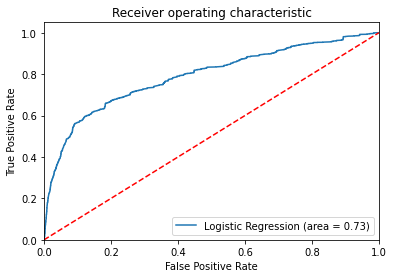

In [272]:
logit_roc_auc = roc_auc_score(y_test_log1, clf_log2.predict(x_test_log1))
fpr, tpr, thresholds = roc_curve(y_test_log1, clf_log2.predict_proba(x_test_log1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Compare the features selected using two logistic regression:
(same scores)

1.['loan', 'contact', 'previous', 'euribor3m', 'job_blue-collar', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may','month_oct', 'day_of_week_mon']

2.['contact', 'previous', 'euribor3m', 'job_blue-collar', 'job_retired',
 'job_services', 'job_student', 'month_dec', 'month_jul', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'day_of_week_mon','poutcome_success']

Most of them are same, instead of loan,  job_self-employed,  month_jun, job_student.